### Introduction

In [108]:
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

Now, let's see how big the data exactly is and how it looks like

In [109]:
messages = [line.rstrip() for line in open('SMS_Data/SMSSpamCollection')]
print(len(messages))

5574


In [110]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 1

As we can see, this look like a TSV file with two columns. First one is a label, telling whether the message is a spam or a normal text ('ham'). Second is a message itself.  
Let's read the file using pandas.

In [111]:
messages = pd.read_csv('SMS_Data/SMSSpamCollection', sep='\t', names=['Label', 'Message'])
messages.head(5)

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Exploratory Data Analysys

Let's see how the length of the message corresponds with the label category. For that, a column with message length is needed.

In [112]:
messages['Length'] = messages['Message'].apply(len)

Check what's the average length and how long are the shortest and longest messages.

In [113]:
messages['Length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: Length, dtype: float64

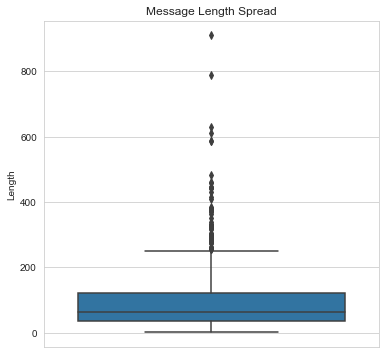

In [114]:
plt.figure(figsize=(6, 6))
plt.title('Message Length Spread')
sns.boxplot(y=messages['Length']);

Looks like there are two local peaks, one around 50 and one around 150 words 

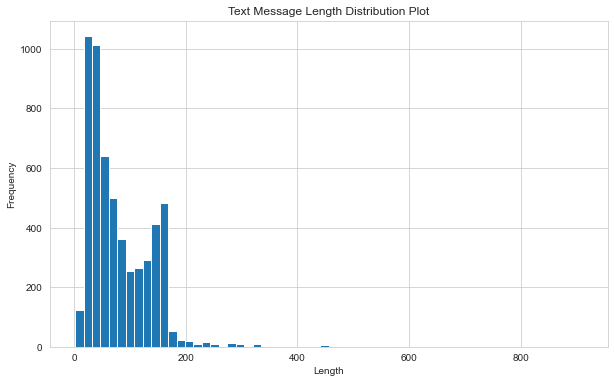

In [135]:
plt.figure(figsize=(10, 6))
plt.title('Text Message Length Distribution Plot')
plt.xlabel('Length')
sns.set_style('whitegrid')
messages['Length'].plot(bins=60, kind='hist');

It seems that spam messages tend to be longer than normal ones

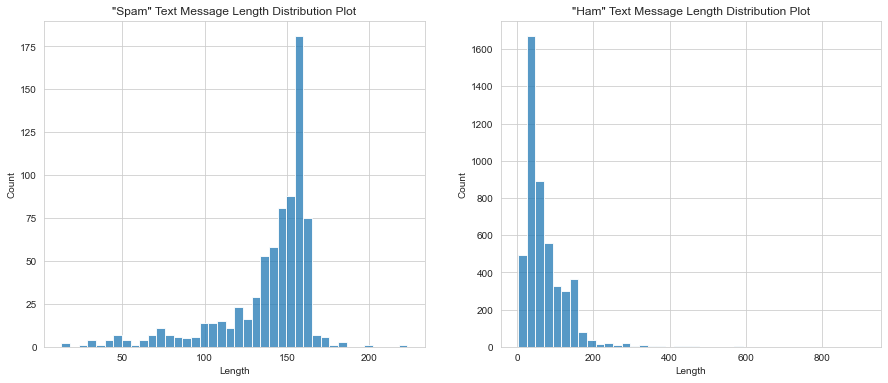

In [116]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.title('"Spam" Text Message Length Distribution Plot')
sns.histplot(messages[messages['Label'] == 'spam']['Length'], bins=40);

plt.subplot(1,2,2)
plt.title('"Ham" Text Message Length Distribution Plot')
sns.histplot(messages[messages['Label'] == 'ham']['Length'], bins=40);

### Creating an anti-spam detector

#### Vectorizing

Removing punctuation form the text.

In [117]:
def text_clean(text):
    no_punc = [character for character in text if character not in string.punctuation]
    no_punc = ''.join(no_punc)
    return [word for word in no_punc.split()]

Creating a matrix where rows are the unique words in all the messages and columns are the messages.  
Using CountVectorizer from SKLearn package with custom text_clean function.

In [118]:
transformer = CountVectorizer(analyzer=text_clean).fit(messages['Message'])
messages_trans = transformer.transform(messages['Message'])

Let's see how many distinct words are in all 5572 messages.

In [119]:
print(messages_trans.shape)

(5572, 11747)


#### Training a model

Splitting the data into train and test sets.

In [120]:
msg_train, msg_test, label_train, label_test = train_test_split(messages_trans, messages['Label'], test_size=0.3, random_state=101)

In [121]:
print('Train messages:')
print(msg_train.shape[0])
print('\n')
print('Test messages:')
print(msg_test.shape[0])

Train messages:
3900


Test messages:
1672


Training the model using Naive Bayes classifier.

In [122]:
spam_detect_model = MultinomialNB().fit(msg_train, label_train)

Evaluating how well the model performs.

In [123]:
all_predictions = spam_detect_model.predict(msg_test)
print('Confusion Matrix')
print('\n')
print(confusion_matrix(label_test, all_predictions))
print('\n')
print('Classification Report')
print('\n')
print(classification_report(label_test, all_predictions))
print('\n')
print('Prediction accuracy: ' + str((spam_detect_model.score(msg_test, label_test)*100).round(2))+'%')

Confusion Matrix


[[1438   37]
 [  21  176]]


Classification Report


              precision    recall  f1-score   support

         ham       0.99      0.97      0.98      1475
        spam       0.83      0.89      0.86       197

    accuracy                           0.97      1672
   macro avg       0.91      0.93      0.92      1672
weighted avg       0.97      0.97      0.97      1672



Prediction accuracy: 96.53%


Confusion Matrix tells that the model predicted 1614 values correctly and 58 incorrectly (37 ham messages classified as spam and 21 spam messages classified as ham).  

Classification Reports shows some more metrics.  
Accuracy is the fraction of predictions that our model got right. In this case it's 96.53%.
Precision tells that out of all the messages that the model predicted to be spam, only 83% was actual spam.  
Recall tells that of all the spam messages, model predicted it correctly only in 89%.  
F1-score is a metric that should be as close to 1 as possible.  

In this case the model is doing ok. Let's see if it can do even better.

### Optimization

To increase the performance of the model, 3 more things can be added to the process:  
1. Removing the stopwords using Natural Language Processing package
2. Applying TF-IDF (frequency-inverse document frequency) to even the relevance of the words  
3. Changing the classifier

#### Vectorizing

Removing punctuation form the text. Rewritten function to include stopwords removal.

In [124]:
def text_clean_opt(text):
    no_punc = [character for character in text if character not in string.punctuation]
    no_punc = ''.join(no_punc)
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

Creating a matrix where rows are the unique words in all the messages and columns are the messages.  
Using CountVectorizer from SKLearn package with custom text_clean function.

In [125]:
transformer_opt = CountVectorizer(analyzer=text_clean_opt).fit(messages['Message'])
messages_trans_opt = transformer_opt.transform(messages['Message'])

Let's see how many distinct words are in all 5572 messages after removing the stopwords.

In [126]:
print(messages_trans_opt.shape)

(5572, 11425)


Applying TF-IDF.

In [127]:
tfidf_transformer = TfidfTransformer().fit(messages_trans_opt)
messages_tfidf = tfidf_transformer.transform(messages_trans_opt)

#### Training a model

Splitting the data into train and test sets.

In [128]:
msg_opt_train, msg_opt_test, label_opt_train, label_opt_test = train_test_split(messages_tfidf, messages['Label'], test_size=0.3, random_state=101)

In [129]:
print('Train messages:')
print(msg_opt_train.shape[0])
print('\n')
print('Test messages:')
print(msg_opt_test.shape[0])

Train messages:
3900


Test messages:
1672


Training the model using Naive Bayes classifier.

In [130]:
spam_detect_model_opt = MultinomialNB().fit(msg_opt_train, label_opt_train)

Evaluating how well the model performs.

In [131]:
all_predictions_opt = spam_detect_model_opt.predict(msg_opt_test)
print('Confusion Matrix')
print('\n')
print(confusion_matrix(label_opt_test, all_predictions_opt))
print('\n')
print('Classification Report')
print('\n')
print(classification_report(label_opt_test, all_predictions_opt))
print('\n')
print('Prediction accuracy: ' + str((spam_detect_model_opt.score(msg_opt_test, label_opt_test)*100).round(2))+'%')

Confusion Matrix


[[1475    0]
 [  71  126]]


Classification Report


              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1475
        spam       1.00      0.64      0.78       197

    accuracy                           0.96      1672
   macro avg       0.98      0.82      0.88      1672
weighted avg       0.96      0.96      0.95      1672



Prediction accuracy: 95.75%


There are no false positives, but the number of false negatives increased.  
That means the anti spam detector is more 'leaky' to spam, but it won't delete normal messages. 


Changing the model to Random Forest.  
Training the model.

In [132]:
spam_detect_model_opt_forest = RandomForestClassifier().fit(msg_opt_train, label_opt_train)

Evaluating how well the model performs.

In [136]:
all_predictions_opt_forest = spam_detect_model_opt_forest.predict(msg_opt_test)
print('Confusion Matrix')
print('\n')
print(confusion_matrix(label_opt_test, all_predictions_opt_forest))
print('\n')
print('Classification Report')
print('\n')
print(classification_report(label_opt_test, all_predictions_opt_forest))
print('\n')
print('Prediction accuracy: ' + str((spam_detect_model_opt_forest.score(msg_opt_test, label_opt_test)*100).round(2))+'%')

Confusion Matrix


[[1474    1]
 [  43  154]]


Classification Report


              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1475
        spam       0.99      0.78      0.88       197

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672



Prediction accuracy: 97.37%


Now it looks like this has the best performance so far. Only 44 incorrect predictions.  

### Conclusions

There is a lot of optimization possibilities to try with this project.  
Firstly, there are lots of other text pre-processing techniques that can be applied to the text before vectorizing it (such as ['stemming'](https://en.wikipedia.org/wiki/Stemming)).  
Secondly, a lot more different classifiers that can prove to be more efficient in this specific situation.  
Also, deep understanding of the data can help to know what results should be achieved.